In [1]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import colors
from matplotlib import cm
import matplotlib
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from scipy.interpolate import interpn
# from scipy.interpolate import interpn
# from mpl_toolkits.basemap import Basemap
import math
import warnings
%matplotlib inline
import xarray as xr
#import bisect

#warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
# from matplotlib import cm
# from matplotlib.collections import LineCollection
# from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10_frc/waom10extend_grd.nc')

In [3]:
x = (ds.variables['Xgrid'].values)
y = (ds.variables['Ygrid'].values)
print(x.shape)
#depth = (ds.variables['depth'][-1].values)

# divide the normal grid by 10
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]
print(xbins.shape,ybins.shape)

(65717, 5460)
(630,) (560,)


In [4]:
# index of bins the particles ending in
x_new = np.digitize(x,xbins)
y_new = np.digitize(y,ybins)

### Residence time

In [5]:
# each row is 900 seconds
x_new[:,0]

array([630, 546, 545, ..., 531, 531, 531])

In [6]:
x_new

array([[630, 630, 630, ..., 630, 630, 630],
       [546, 630, 630, ..., 630, 630, 630],
       [545, 630, 630, ..., 630, 630, 630],
       ...,
       [531, 483, 521, ..., 455, 518, 472],
       [531, 483, 521, ..., 455, 518, 472],
       [531, 483, 521, ..., 455, 518, 472]])

In [7]:
# mesh.shape

In [8]:
m2 = []
for i in range(len(xbins)):
    newl = []
    for j in range(len(ybins)):
        newl.append([])
        
    m2.append(newl)

In [9]:
import time

In [10]:
len(x_new[0])

5460

In [11]:
# each bin has an average or total time that any one particle spends in it

# for each column\
start_time = time.time()
for i in range(x_new.shape[1]):
#for i in range(1000):
    if i % 1000 == 0:
        print(i,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # get the x and y column values
    thisx = x_new[:,i]
    thisy = y_new[:,i]

    # make a stack of the x and y columns
    pts = np.vstack((thisx,thisy))
    pts = pts.T

    # normalize to the total number of particles
    counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
    counts.pop()
    
    # add each count to a list in the mesh
    for ii in counts[:-1]:
        iind = ii[0][0]
        jind = ii[0][1]
        
        # create the mesh without the scaling by time
        myval = (ii[1]*900)/86400 # current sum of the column totals

        # see if the current number of the mesh is zero, if it is, add to list
        #print(m2[iind][jind])
        
        m2[int(iind)][int(jind)].append(myval)
#print(m2)

0 of 5460 in 2.4278958638509115e-06
1000 of 5460 in 0.6525183757146199
2000 of 5460 in 1.298980673154195
3000 of 5460 in 1.9596726338068644
4000 of 5460 in 2.6394492467244466
5000 of 5460 in 3.3146395166714986


In [16]:
# AVERAGE MESH
mesh = np.zeros((len(xbins),len(ybins)))

# create the mesh based on averages of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = sum(m2[ii][jj])/len(m2[ii][jj])
            if avg<200:
                mesh[ii][jj] = avg
            else:
                print(avg)

In [30]:
# MAX MESH
mesh_max = np.zeros((len(xbins),len(ybins)))

# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = max(m2[ii][jj])
            #print(avg)
            mesh_max[ii][jj] = avg
            #else:
            #    print(avg)

In [20]:
# MIN MESH
mesh_min = np.zeros((len(xbins),len(ybins)))

# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = min(m2[ii][jj])
            if avg<200:
                mesh_min[ii][jj] = avg
            #else:
            #    print(avg)

In [21]:
# STDEV MESH
mesh_std = np.zeros((len(xbins),len(ybins)))

# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = np.std(m2[ii][jj])
            #if avg<200:
            mesh_std[ii][jj] = avg

In [22]:
[Xbins, Ybins] = np.meshgrid(ybins,xbins)
print(Xbins.shape)

(630, 560)


In [23]:
# write the mesh to a text file
# # transform the Ybins and Xbins into lat/long points
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values
print(lat_values.shape)
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

(560, 630)


/scratch/project_2000789/muramarg/miniconda3/envs/myenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/scratch/project_2000789/muramarg/miniconda3/envs/myenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/scratch/project_2000789/muramarg/miniconda3/envs/myenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply ex

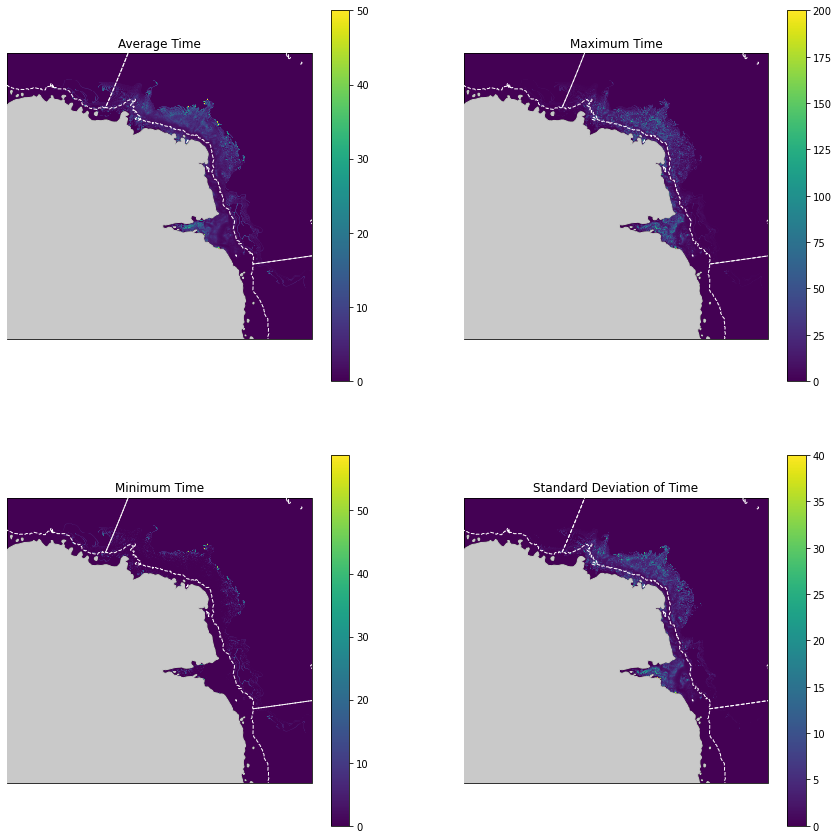

In [40]:
# average values
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=50)
plt.colorbar()
plt.title("Average Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

# maximum values
ax = fig.add_subplot(2, 2, 2, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh_max[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=200)
plt.colorbar()
plt.title("Maximum Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

# minimum values
ax = fig.add_subplot(2, 2, 3, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh_min[300:,250:],transform=ccrs.PlateCarree(),zorder=2)
plt.colorbar()
plt.title("Minimum Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

# standard deviation
ax = fig.add_subplot(2, 2, 4, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh_std[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=40)
plt.colorbar()
plt.title("Standard Deviation of Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

plt.savefig('4diags.png')



#myds = ds1.temp[xlimit,ylimit]
#ds1.h.isel(xi_rho=slice(350, 630),eta_rho=slice(300,630)).plot(x="lon_rho", y="lat_rho",transform=ccrs.PlateCarree())

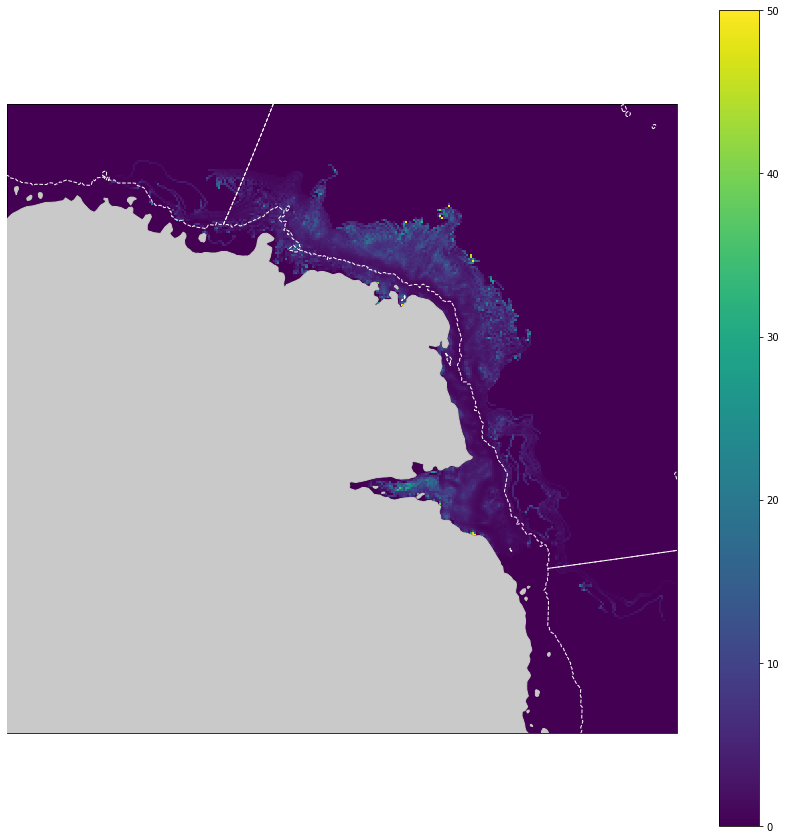

In [64]:
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection=proj) 
#ds1.temp.isel(ocean_time=1).plot(transform=ccrs.PlateCarree())
#ax.coastlines(facecolor='white',edgecolor='black')
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')

xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
#plt.pcolormesh(dg.lon_rho[300:560,200:630],dg.lat_rho[300:560,200:630],ds1.temp.isel(xi_rho=slice(200, 630),eta_rho=slice(300,560)),transform=ccrs.PlateCarree())
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=50)
plt.colorbar()
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
#plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.h[xlimit,ylimit],levels=[200,400,600],zorder=5, linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
#bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)
#fig.subplots_adjust(left=100, bottom=10, right=110, top=11, wspace=0, hspace=0)
#fig.colorbar(fig, ax=ax)

plt.savefig('2_year_EastAnt.png')



#myds = ds1.temp[xlimit,ylimit]
#ds1.h.isel(xi_rho=slice(350, 630),eta_rho=slice(300,630)).plot(x="lon_rho", y="lat_rho",transform=ccrs.PlateCarree())

### Create density map

In [65]:
import time

In [66]:
x_sing = np.array([])
y_sing = np.array([])
start_time = time.time()
for col in range(x_new.shape[1]):
    if col % 500 == 0:
        print(col,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # create a set of datapoints
    thisx = (x_new[:,col])
    thisy = (y_new[:,col])
    
    # create the array of the colum
    arr = np.vstack((thisx,thisy))
    arr = arr.T
    
    # create a set from the array so each coordinate visits each grid square once
    set_coords = list(set(map(tuple,arr)))
    for myset in set_coords:
        x_sing = np.append(x_sing,myset[0])
        y_sing = np.append(y_sing,myset[1])

0 of 5460 in 1.8795331319173178e-06
500 of 5460 in 0.5572355667750041
1000 of 5460 in 1.573765496412913
1500 of 5460 in 2.877283771832784
2000 of 5460 in 4.69228013753891
2500 of 5460 in 7.322642024358114
3000 of 5460 in 10.348594661553701
3500 of 5460 in 13.950692876180012
4000 of 5460 in 18.333011988798777
4500 of 5460 in 22.986044239997863
5000 of 5460 in 28.02060699860255


In [67]:
pts = np.vstack((x_sing,y_sing))
pts = pts.T

# normalize to the total number of particles
counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
num_positions = len(counts)
#print(counts)
print(num_positions)

9961


In [68]:
# pop the nan values
counts.pop()

(array([630., 560.]), 5460)

In [69]:
# we are dividing by the number of particles, not number of positions
num_particles = x.shape[1]
print(num_particles)

5460


In [79]:
mesh = np.zeros((len(xbins),len(ybins)))

for ii in counts[:-1]:
    iind = ii[0][0]
    jind = ii[0][1]
    # create the mesh without the scaling by time
    myval = ii[1]/num_particles
    
    # scale by time for one day
    myval = (myval/900)*86400
    
    mesh[int(iind)][int(jind)] = myval
    
    # 
mesh

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03516484, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [80]:
[Xbins, Ybins] = np.meshgrid(ybins,xbins)
print(Xbins.shape)

(630, 560)


In [81]:
# # transform the Ybins and Xbins into lat/long points
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values
print(lat_values.shape)
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

(560, 630)


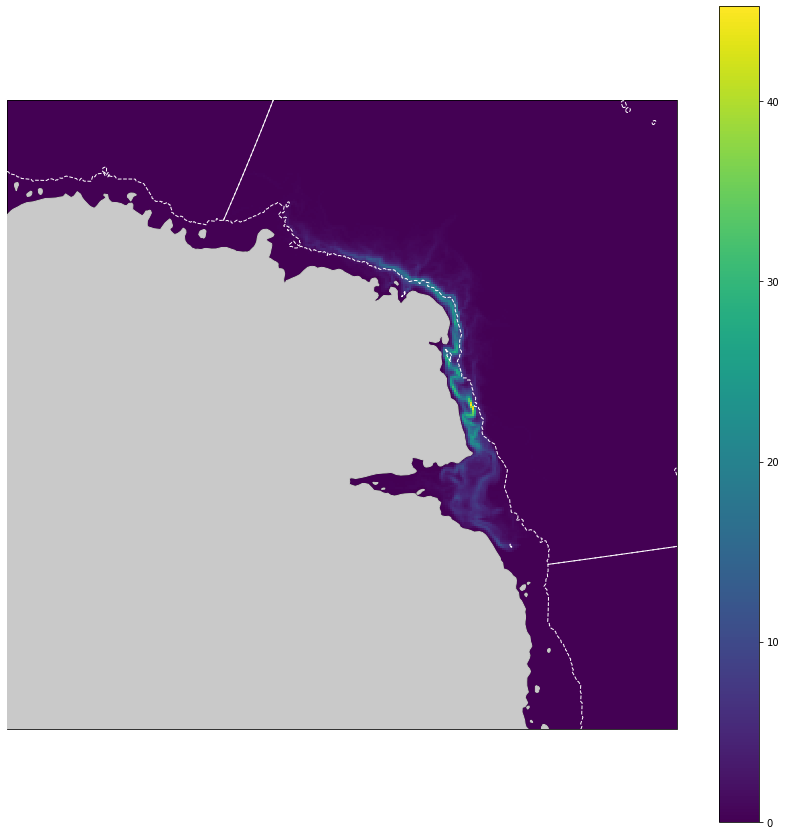

In [82]:
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection=proj) 
#ds1.temp.isel(ocean_time=1).plot(transform=ccrs.PlateCarree())
#ax.coastlines(facecolor='white',edgecolor='black')
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')

xlimit = np.arange(300,500,1)
ylimit = np.arange(400,600,1)
#plt.pcolormesh(dg.lon_rho[300:560,200:630],dg.lat_rho[300:560,200:630],ds1.temp.isel(xi_rho=slice(200, 630),eta_rho=slice(300,560)),transform=ccrs.PlateCarree())
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh[300:,250:],transform=ccrs.PlateCarree(),zorder=2)
plt.colorbar()
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
#plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.h[xlimit,ylimit],levels=[200,400,600],zorder=5, linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
#bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)
#fig.subplots_adjust(left=100, bottom=10, right=110, top=11, wspace=0, hspace=0)
#fig.colorbar(fig, ax=ax)

plt.savefig('2_year_EastAnt_density.png')



#myds = ds1.temp[xlimit,ylimit]
#ds1.h.isel(xi_rho=slice(350, 630),eta_rho=slice(300,630)).plot(x="lon_rho", y="lat_rho",transform=ccrs.PlateCarree())